# Skin Lesion Prediction - Model Tuning and Evaluation

Following model definition and training is model tuning and evaluation

## Model Evaluation

Model evaluation is a critical task in data science. This is one of the few measures business stakeholders are interested in. Model performance heavily influences business impact of a data science project. Therefore, it is important to take some time apart in an independent task in the process model. 

In supervised learning (classification and regression) we need to define a different measure for evaluation than in unsupervised learning (clustering). Since it depends on the type of model we create, the following none exhaustive lists can be used as a starting point for further research:

#### Classification:            
* Confusion Matrix                      
* Accuracy
* Precision
* Recall
* Specificity
* True positive rate
* True negative rate
* False positive rate
* False negative rate
* F1-score
* Gain and Lift
* Kolomogorov Smirnov
* Area Under ROC
* Gini Coefficient
* Concordant – Discordant ratio

#### Regression:
* Root Mean Squared Error (RMSE)
* Mean Squared Error
* Mean Absolute Error (MAE)
* R-Squared
* Relative Squared Error
* Relative Absolute Error
* Sum of Differences
* ACF plot of residuals
* Histogram of residuals
* Residual plots against predictors
* Residual plots against fitted values

#### Clustering:
* Adjusted Rand index
* Mutual Information
* Homogeneity completeness
* V-measure
* Fowlkes-Mallows
* Silhouette Coefficient Calinski-Harabaz

#### References: http://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation

### Loading imports and dataset

In [4]:
%matplotlib inline
#import scikitplot as skplt
import matplotlib.pyplot as plt
import numpy as np
#!pip install pandas-profiling
#!pip install tensorflow==2.2
#!pip install imblearn
#!pip install delayed

from imblearn.over_sampling import SMOTE
import sklearn.utils.fixes
import pandas as pd
import pandas_profiling
from pandas_profiling import ProfileReport
import os
import itertools
#import keras
import seaborn as sns
import plotly
import plotly.graph_objs as go

#plt.style.use("seaborn-whitegrid")
from glob import glob
from PIL import Image
import matplotlib.image as mpimg

np.random.seed(123)

#!pip install scikit-learn
import sklearn
import scikitplot as skplt
import sklearn.feature_selection
from sklearn.preprocessing import label_binarize,OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

#!pip install keras
from tensorflow import keras
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras import backend as K
from keras import regularizers
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from keras.layers.normalization import BatchNormalization
from collections import Counter
from imblearn.over_sampling import SMOTE 

import graphviz

Using TensorFlow backend.


In [5]:
#load skindf data set
skindf = pd.read_csv('skindf.csv')
skindf.head(2)

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label,sex,localization,age
0,192,153,193,195,155,192,197,154,185,202,...,183,147,166,185,154,177,2,0,0,80
1,25,14,30,68,48,75,123,93,126,158,...,25,14,28,25,14,27,2,0,0,80


In [6]:
X = skindf.drop(['label'],axis=1).copy() 
y = skindf['label'].copy()

In [7]:
X.shape

(10015, 2355)

In [8]:
y.shape

(10015,)

### Class label mapping

In [9]:
# For class label mapping

class_label = {
    0: 'nv: melanocytic nevi',
    1: 'mel: melanoma',
    2: 'bkl: benign keratosis-like lesion',
    3: 'bcc: basal_cell_carcinoma',
    4: 'akiec: actinic_keratoses',
    5: 'vasc: vascular lesion',
    6: 'df: dermatofibroma'
}

### 1. Data Preparation

Dataset has imbalanced classes and pixel dimensions that need to be delt with. We will use SMOTE (Synthetic Minority Oversampling Technique), Standared Scaler, and Principal Component Analysis.



#### Examine the classes

In [10]:
import imblearn
from collections import Counter
print(imblearn.__version__)
counter = Counter(y)
print(counter)

0.7.0
Counter({4: 6705, 6: 1113, 2: 1099, 1: 514, 0: 327, 5: 142, 3: 115})


In [11]:
import matplotlib.pyplot as pyplot
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

# label encode the target variable
y = LabelEncoder().fit_transform(y)

# summarize distribution
counter = Counter(y)
for k,v in counter.items():
    per = v / len(y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

Class=2, n=1099 (10.974%)
Class=4, n=6705 (66.950%)
Class=3, n=115 (1.148%)
Class=6, n=1113 (11.113%)
Class=5, n=142 (1.418%)
Class=1, n=514 (5.132%)
Class=0, n=327 (3.265%)


#### Apply SMOTE to correct the imbalance

In [12]:
#Default SMOTE Strategy to oversample all classes to the number of examples
#from imblearn.over_sampling import SMOTE
#from sklearn.preprocessing import LabelEncoder in the majority class

# label encode the target variable
y = LabelEncoder().fit_transform(y)

# transform the dataset
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

# summarize distribution
counter = Counter(y)
for k,v in counter.items():
    per = v / len(y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

Class=2, n=6705 (14.286%)
Class=4, n=6705 (14.286%)
Class=3, n=6705 (14.286%)
Class=6, n=6705 (14.286%)
Class=5, n=6705 (14.286%)
Class=1, n=6705 (14.286%)
Class=0, n=6705 (14.286%)


In [13]:
X.shape

(46935, 2355)

In [14]:
y.shape

(46935,)

In [15]:
X = np.array(X)
print(X.shape)

(46935, 2355)


#### Split dataset into training and test sets.

In [16]:
X_train,X_test, y_train,y_test = train_test_split(X,y,train_size=0.9,random_state=0)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

#### Scale the data

In [17]:
#standard scaler 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Fit on training set only.
scaler.fit(X_train)

# Apply transform to both the training set and the test set.
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

#### Apply PCA

In [18]:
from sklearn.decomposition import PCA

#Make an instance of the Model
pca = PCA(.95) #testing 80% use .80 etc

In [19]:
#Fit PCA on training set
pca.fit(X_train)

PCA(n_components=0.95)

In [20]:
#Check number of components
pca.n_components_

58

In [21]:
#Apply transform 
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

In [22]:
X_test.shape

(4694, 58)

In [23]:
y_test.shape

(4694,)

In [24]:
X_train.shape

(42241, 58)

In [25]:
y_train.shape

(42241,)

In [26]:
X_train.shape

(42241, 58)

In [27]:
n_cols = X_train.shape[1]
n_cols

58

### 2.  Model Tuning and Evaluation

### Grid Search
#### For tuning of the best performing model

We will be searching through activation functions and optimizers comparing the results with the best peforming model from the model definition and training phase. 

In [33]:
# To remove any models if run before
!rm -f ker_*

 Define the parameter grid using the best performing Keras model.

In [34]:
#define parameter grid
batch_size = 850
num_classes = 7 
epochs = 100
es = EarlyStopping(monitor='val_loss', mode='auto', patience=5, restore_best_weights=True,
 verbose=1)

activation_functions_layer = ['selu','relu','elu'] 
activation_functions_layer_2 = ['elu','relu','selu']
opimizers = ['adam','nadam','sgd']

#optimize over parameter grid (grid search)

for activation_function_layer in activation_functions_layer:
    for activation_function_layer_2 in activation_functions_layer_2:
        for opimizer in opimizers:
            
    
    
        
            model = Sequential()
            model.add(Dense(512, activation = activation_function_layer, input_shape=(n_cols,)))
            model.add(Dense(64, activation = activation_function_layer_2))
            model.add(Dropout(0.20))
            model.add(Dense(num_classes, activation='softmax'))



            model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opimizer,
              metrics=['accuracy'])

            history = model.fit(X_train, y_train, 
              batch_size=batch_size,
              epochs=epochs,
              callbacks=[es],        
              verbose=1,
              validation_data=(X_test, y_test))
        
            score = model.evaluate(X_test, y_test, verbose=0)
            save_path = "ker_tuned_Hamskin_model.%s.%s.%s.%s.h5" % (activation_function_layer,activation_function_layer_2,opimizer,score[1])
            
            model.save(save_path)

Train on 42241 samples, validate on 4694 samples
Epoch 1/100
42241/42241 [==============================] - 2s 48us/step - loss: 1.4785 - accuracy: 0.5428 - val_loss: 0.7732 - val_accuracy: 0.7286
Epoch 2/100
42241/42241 [==============================] - 2s 39us/step - loss: 0.7588 - accuracy: 0.7319 - val_loss: 0.5954 - val_accuracy: 0.8002
Epoch 3/100
42241/42241 [==============================] - 1s 35us/step - loss: 0.6105 - accuracy: 0.7866 - val_loss: 0.5010 - val_accuracy: 0.8360
Epoch 4/100
42241/42241 [==============================] - 1s 32us/step - loss: 0.5252 - accuracy: 0.8169 - val_loss: 0.4362 - val_accuracy: 0.8539
Epoch 5/100
42241/42241 [==============================] - 2s 37us/step - loss: 0.4523 - accuracy: 0.8444 - val_loss: 0.3774 - val_accuracy: 0.8790
Epoch 6/100
42241/42241 [==============================] - 2s 41us/step - loss: 0.4000 - accuracy: 0.8643 - val_loss: 0.3454 - val_accuracy: 0.8845
Epoch 7/100
42241/42241 [==============================] - 2s 4

Show saved models. 

In [35]:
ls -ltr ker_*

 Volume in drive C is Windows
 Volume Serial Number is 901D-281F

 Directory of C:\Users\celie


 Directory of C:\Users\celie

06/03/2021  02:35 PM           789,296 ker_tuned_Hamskin_model.elu.elu.adam.0.9708138108253479.h5
06/03/2021  02:36 PM           786,912 ker_tuned_Hamskin_model.elu.elu.nadam.0.9735832810401917.h5
06/03/2021  02:37 PM           530,744 ker_tuned_Hamskin_model.elu.elu.sgd.0.9020025730133057.h5
06/03/2021  02:38 PM           789,296 ker_tuned_Hamskin_model.elu.relu.adam.0.9714528918266296.h5
06/03/2021  02:39 PM           786,912 ker_tuned_Hamskin_model.elu.relu.nadam.0.9733702540397644.h5
06/03/2021  02:40 PM           530,744 ker_tuned_Hamskin_model.elu.relu.sgd.0.9034938216209412.h5
06/03/2021  02:41 PM           789,296 ker_tuned_Hamskin_model.elu.selu.adam.0.9701746702194214.h5
06/03/2021  02:42 PM           786,912 ker_tuned_Hamskin_model.elu.selu.nadam.0.9552620649337769.h5
06/03/2021  02:44 PM           530,744 ker_tuned_Hamskin_model.elu.selu.sgd.0.90967

### 3. Load and Evaluate the Best Model from Grid Search

In [36]:
tuned_model = keras.models.load_model('ker_tuned_Hamskin_model.relu.selu.adam.0.9740093946456909.h5')

In [37]:
tuned_model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_46 (Dense)             (None, 512)               30208     
_________________________________________________________________
dense_47 (Dense)             (None, 64)                32832     
_________________________________________________________________
dropout_16 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_48 (Dense)             (None, 7)                 455       
Total params: 63,495
Trainable params: 63,495
Non-trainable params: 0
_________________________________________________________________


#### Evaluate Test Loss and Accuracy

In [38]:
# Print model fitting summury 
score = tuned_model.evaluate(X_test, y_test, verbose=0)
prediction_cplx = tuned_model.predict_classes(X_test)

print(tuned_model.summary())
print('train samples:', X_train.shape[0])
print('test samples:', X_test.shape[0])
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_46 (Dense)             (None, 512)               30208     
_________________________________________________________________
dense_47 (Dense)             (None, 64)                32832     
_________________________________________________________________
dropout_16 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_48 (Dense)             (None, 7)                 455       
Total params: 63,495
Trainable params: 63,495
Non-trainable params: 0
_________________________________________________________________
None
train samples: 42241
test samples: 4694
Test loss: 0.09493885069139521
Test accuracy: 0.9740094


#### Check Classification Report

In [39]:
print(classification_report(y_test.astype(int), prediction_cplx))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       665
           1       0.98      1.00      0.99       676
           2       0.96      0.97      0.96       670
           3       1.00      1.00      1.00       621
           4       0.96      0.89      0.92       695
           5       1.00      1.00      1.00       705
           6       0.93      0.97      0.95       662

    accuracy                           0.97      4694
   macro avg       0.97      0.97      0.97      4694
weighted avg       0.97      0.97      0.97      4694



#### Confusion Matrix

Text(0.5, 15.0, 'Predicted Class')

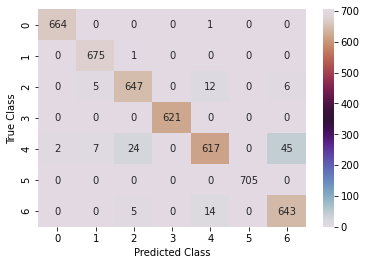

In [40]:
cm = confusion_matrix(y_test,prediction_cplx)
#plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cbar=True, cmap='twilight')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')

#### Calculate Performance Metrics from the Confusion Matrix 

In [41]:
#Performance metrics from confusion matrix 

FP = cm.sum(axis=0) - np.diag(cm) 
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# Sensitivity, hit rate, Recall, or true positive rate
TPR = TP/(TP+FN)

# Specificity or true negative rate
TNR = TN/(TN+FP) 

# Precision or positive predictive value
PPV = TP/(TP+FP)

# Negative predictive value
NPV = TN/(TN+FN)

# Fall out or false positive rate
FPR = FP/(FP+TN)

# False negative rate
FNR = FN/(TP+FN)

# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy for each class
#ACC = (TP+TN)/(TP+FP+FN+TN)

print(class_label)

print('Specificity:',TNR)
print('Specificity Mean:',TNR.mean())

print('Recall/Sensitivity:',TPR)
print('Recall/Sensitivity Mean:',TPR.mean())

print('Precision:',PPV)
print('Precision Mean:',PPV.mean())

{0: 'nv: melanocytic nevi', 1: 'mel: melanoma', 2: 'bkl: benign keratosis-like lesion', 3: 'bcc: basal_cell_carcinoma', 4: 'akiec: actinic_keratoses', 5: 'vasc: vascular lesion', 6: 'df: dermatofibroma'}
Specificity: [0.9995036  0.99701344 0.99254473 1.         0.99324831 1.
 0.98735119]
Specificity Mean: 0.9956658960849453
Recall/Sensitivity: [0.99849624 0.99852071 0.96567164 1.         0.88776978 1.
 0.97129909]
Recall/Sensitivity Mean: 0.9745367814685674
Precision: [0.996997   0.98253275 0.95568685 1.         0.95807453 1.
 0.92651297]
Precision Mean: 0.9742577291880743


#### ROC Scores for multiclass 

In [47]:
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score


#y_prob = classifier.predict_proba(X_test)

prediction_cplx = tuned_model.predict_proba(X_test)

macro_roc_auc_ovo = roc_auc_score(y_test, prediction_cplx, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, prediction_cplx, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test, prediction_cplx, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, prediction_cplx, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

One-vs-One ROC AUC scores:
0.997868 (macro),
0.997844 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.997855 (macro),
0.997813 (weighted by prevalence)


#### ROC curve for multiclass

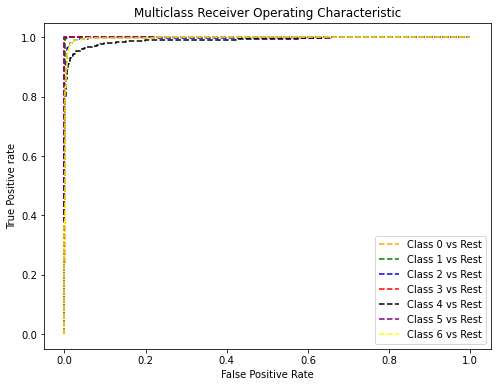

In [48]:
#ROC for multi-class classification model, balanced data (SMOTE)
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score


prediction_cplx = tuned_model.predict_proba(X_test)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 7

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, prediction_cplx[:,i], pos_label=i)
    
# plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='black', label='Class 4 vs Rest')
plt.plot(fpr[5], tpr[5], linestyle='--',color='purple', label='Class 5 vs Rest')
plt.plot(fpr[6], tpr[6], linestyle='--',color='yellow', label='Class 6 vs Rest')
plt.title('Multiclass Receiver Operating Characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300); 

### 4. Make a Prediction from an image not in the original dataset
A new image of a skin lesion is gathered from an outside source and not from the dataset used for training and testing.

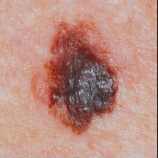

In [61]:
from keras.preprocessing import image

img_path = ('C:/Users/celie/Desktop/mel2.jpg')
img = image.load_img(img_path, target_size=(158,158))
img

In [60]:
# Classify image not in the dataset
import cv2
img = cv2.imread('C:/Users/celie/Desktop/mel2.jpg',0)


img = cv2.resize(img,(58,58))
cv2.waitKey(0)
cv2.destroyAllWindows()

print(class_label)

prediction_cplx = tuned_model.predict_classes(img)

print('The predicted class of the lesion is:', prediction_cplx[1])

{0: 'nv: melanocytic nevi', 1: 'mel: melanoma', 2: 'bkl: benign keratosis-like lesion', 3: 'bcc: basal_cell_carcinoma', 4: 'akiec: actinic_keratoses', 5: 'vasc: vascular lesion', 6: 'df: dermatofibroma'}
The predicted class of the lesion is: 1


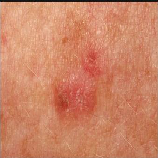

In [216]:
from keras.preprocessing import image

img_path = ('C:/Users/celie/Desktop/acct2.jpg')
img = image.load_img(img_path, target_size=(158,158))
img

In [217]:
# Classify image not in the dataset
import cv2
img = cv2.imread('C:/Users/celie/Desktop/acct2.jpg',0)


img = cv2.resize(img,(58,58))
cv2.waitKey(0)
cv2.destroyAllWindows()

print(class_label)

prediction_cplx = tuned_model.predict_classes(img)

print('The predicted class of the lesion is:', prediction_cplx[1])

{0: 'nv: melanocytic nevi', 1: 'mel: melanoma', 2: 'bkl: benign keratosis-like lesion', 3: 'bcc: basal_cell_carcinoma', 4: 'akiec: actinic_keratoses', 5: 'vasc: vascular lesion', 6: 'df: dermatofibroma'}
The predicted class of the lesion is: 4


### Save the new model

In [64]:
tuned_model.save('hamskin_3_58_58.h5')

In [65]:
reconstructed_model = keras.models.load_model('hamskin_3_58_58.h5')
reconstructed_model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_46 (Dense)             (None, 512)               30208     
_________________________________________________________________
dense_47 (Dense)             (None, 64)                32832     
_________________________________________________________________
dropout_16 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_48 (Dense)             (None, 7)                 455       
Total params: 63,495
Trainable params: 63,495
Non-trainable params: 0
_________________________________________________________________


In [66]:
!ls -ltr hamskin_3*

-rw-r--r-- 1 celie celie 797512 Jun  3 15:07 hamskin_3_58_58.h5
